In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, KFold
print(tf.__version__)

2.10.0


In [3]:
data_path = "C:/Users/pathr/Downloads/TCIR-ALL_2017.h5"
data_info = pd.read_hdf(data_path, key="info", mode='r')
with h5py.File(data_path, 'r') as hf:
    data_matrix = hf['matrix'][:]


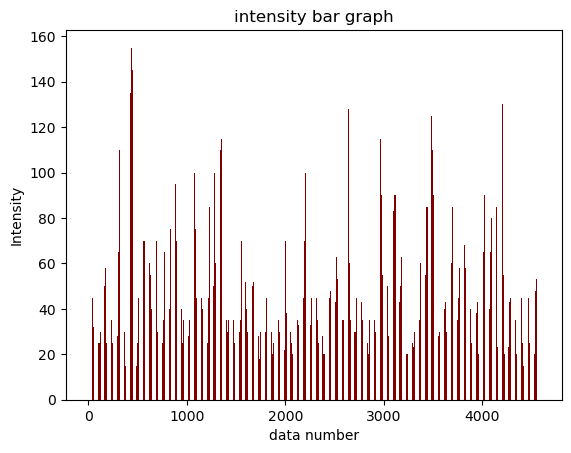

In [5]:

import matplotlib.pyplot as plt
arr=[]
for i in range(1,4581):
    arr.append(i)
plt.bar(arr, data_info['Vmax'], color ='maroon',
        width = 0.4)

plt.xlabel("data number")
plt.ylabel("Intensity")
plt.title("intensity bar graph")
plt.show()

In [6]:
np.shape(data_matrix)

(4580, 201, 201, 4)

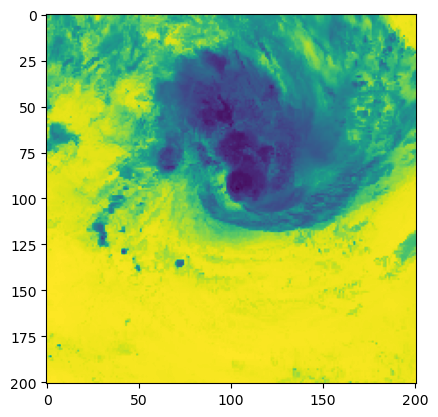

In [7]:
img = data_matrix[4000,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img)

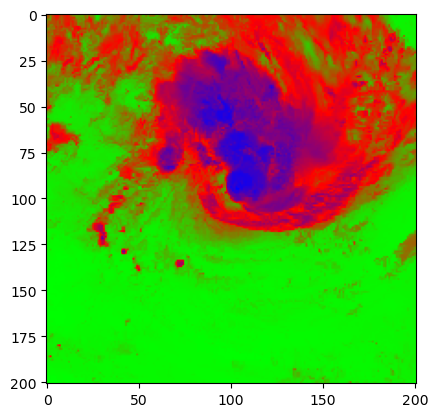

In [10]:
img = data_matrix[4000,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img,plt.cm.brg)

In [12]:
data_info = data_info.assign(time=pd.to_datetime(data_info.time, format=r'%Y%m%d%H'))


In [19]:
## keep only IR and PMW
X_irpmw = data_matrix[:,:,:,0::3]
y = data_info['Vmax'].values[:,np.newaxis]
print(y.shape)
print(X_irpmw.shape)

(4580, 1)
(4580, 201, 201, 2)


In [66]:
X_irpmw[np.isnan(X_irpmw)] = 0
X_irpmw[X_irpmw > 1000] = 0

In [67]:
class Preprocessing(keras.layers.Layer):
    def __init__(self):
        super(Preprocessing, self).__init__()
    def call(self, inputs, training=None):
        if training:
            inputs = tf.image.rot90(inputs, k=np.random.randint(4))
        return tf.image.central_crop(inputs, 0.5)

# Alexnet CNN

In [75]:
def train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size):
    reg_param = 1e-5
    
    train_X = tf.convert_to_tensor(train_x)
    train_Y = tf.convert_to_tensor(train_y)
    
    val_X = tf.convert_to_tensor(val_x)
    val_Y = tf.convert_to_tensor(val_y)
    
    weights_initializer = keras.initializers.GlorotUniform()
    

    model = keras.models.Sequential([
        Preprocessing(),
        keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=4,padding='valid', activation='relu', input_shape=(224,224,3)),
        keras.layers.MaxPool2D(pool_size=(3, 3),strides=2),
        keras.layers.Conv2D(filters=256, kernel_size=(5,5), padding='same', activation='relu'),
        keras.layers.MaxPool2D(pool_size=(3, 3),strides=2),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu'),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu'),
        keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
        keras.layers.MaxPool2D(pool_size=(3, 3),strides=2),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='relu'),
        
        
    ])
    
    #Compiling the model
    model.compile(optimizer=keras.optimizers.Adam(lr=5e-4, beta_1=0.99, beta_2=0.9999),
                  loss='mean_squared_error', 
                  metrics=['mean_squared_error'], 
                 )
 
    #Training the network
    history = model.fit(train_X,train_Y, 
         epochs=n_epochs,
         batch_size=batch_size, 
         verbose=1
        )
    
    val_score = model.evaluate(val_X, val_Y)
    print("Val Score: ",val_score)
    return history,val_score,model

In [76]:
model_history=[]
val_scores=[]
n_epochs=20
batch_size=256
train_x, val_x, train_y, val_y = train_test_split(X_irpmw, y, random_state = 101, test_size=0.1)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, random_state = 101, test_size=0.1)
history,val_score,model = train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size)
model_history.append(history)
val_scores.append(val_score)

Epoch 1/20
15/15 [==============================] - 44s 3s/step - loss: 52460.1992 - mean_squared_error: 52460.1992
Epoch 2/20
15/15 [==============================] - 43s 3s/step - loss: 968.5286 - mean_squared_error: 968.5286
Epoch 3/20
15/15 [==============================] - 45s 3s/step - loss: 862.4940 - mean_squared_error: 862.4940
Epoch 4/20
15/15 [==============================] - 44s 3s/step - loss: 839.9996 - mean_squared_error: 839.9996
Epoch 5/20
15/15 [==============================] - 44s 3s/step - loss: 834.4777 - mean_squared_error: 834.4777
Epoch 6/20
15/15 [==============================] - 44s 3s/step - loss: 809.2913 - mean_squared_error: 809.2913
Epoch 7/20
15/15 [==============================] - 45s 3s/step - loss: 800.1186 - mean_squared_error: 800.1186
Epoch 8/20
15/15 [==============================] - 45s 3s/step - loss: 783.9523 - mean_squared_error: 783.9523
Epoch 9/20
15/15 [==============================] - 45s 3s/step - loss: 768.2657 - mean_squared_erro

In [13]:
y_pred = model.predict(test_x)
print('Testing...')
score = model.evaluate(test_x,test_y,
                     batch_size=16, verbose=1)

print('Test accuracy:', score[1])

13/13 [==============================] - 1s 79ms/step
Testing...
26/26 [==============================] - 1s 39ms/step - loss: 395.8507 - mean_squared_error: 395.8507
Test accuracy: 395.8507385253906


In [14]:
abcd = []
for x in y_pred:
    abcd.append(int(x))

In [15]:
cate = []
for x in abcd:
    if x <=33:
        cate.append('Tropical Depression')
    elif x>33 and x<=63:
        cate.append('Tropical Storm')
    elif x>63 and x<=129:
        cate.append('Typhoon')
    elif x>129:
        cate.append('Super Typhoon')

In [16]:
cate_dataset = list(zip(abcd,cate))

In [18]:
df = pd.DataFrame(cate_dataset,columns=['Intensity','Category',])
df

,Intensity,Category
0,54,Tropical Storm
1,28,Tropical Depression
2,24,Tropical Depression
3,75,Typhoon
4,40,Tropical Storm
...,...,...
408,40,Tropical Storm
409,28,Tropical Depression
410,28,Tropical Depression
411,27,Tropical Depression


# Deep CNN

In [19]:
def train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size):
    reg_param = 1e-5
    
    train_X = tf.convert_to_tensor(train_x)
    train_Y = tf.convert_to_tensor(train_y)
    
    val_X = tf.convert_to_tensor(val_x)
    val_Y = tf.convert_to_tensor(val_y)
    
    weights_initializer = keras.initializers.GlorotUniform()
    

    model = keras.models.Sequential([
        Preprocessing(),
        keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(128, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(1, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
    ])
    #Compiling the model
    model.compile(optimizer=keras.optimizers.Adam(lr=5e-4, beta_1=0.99, beta_2=0.9999),
                  loss='mean_squared_error', 
                  metrics=['mean_squared_error'], 
                 )

    #Training the network
    history = model.fit(train_X,train_Y, 
         epochs=n_epochs,
         batch_size=batch_size, 
         verbose=1
        )
    
    val_score = model.evaluate(val_X, val_Y)
    print("Val Score: ",val_score)
    return history,val_score,model


In [21]:
model_history=[]
val_scores=[]
n_epochs=20
batch_size=64
train_x, val_x, train_y, val_y = train_test_split(X_irpmw, y, random_state = 101, test_size=0.1)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, random_state = 101, test_size=0.1)
history,val_score,model = train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size)
model_history.append(history)
val_scores.append(val_score)

C:\Users\pathr\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20


C:\Users\pathr\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


58/58 [==============================] - 5s 63ms/step - loss: 793.2739 - mean_squared_error: 793.2663
Epoch 2/20
58/58 [==============================] - 4s 66ms/step - loss: 605.0012 - mean_squared_error: 604.9944
Epoch 3/20
58/58 [==============================] - 4s 63ms/step - loss: 522.5802 - mean_squared_error: 522.5741
Epoch 4/20
58/58 [==============================] - 4s 66ms/step - loss: 450.0674 - mean_squared_error: 450.0614
Epoch 5/20
58/58 [==============================] - 4s 65ms/step - loss: 384.4721 - mean_squared_error: 384.4661
Epoch 6/20
58/58 [==============================] - 4s 64ms/step - loss: 347.0807 - mean_squared_error: 347.0746
Epoch 7/20
58/58 [==============================] - 4s 71ms/step - loss: 313.8510 - mean_squared_error: 313.8448
Epoch 8/20
58/58 [==============================] - 4s 67ms/step - loss: 317.7738 - mean_squared_error: 317.7677
Epoch 9/20
58/58 [==============================] - 4s 62ms/step - loss: 325.5394 - mean_squared_error: 325

In [22]:
y_pred = model.predict(test_x)
print('Testing...')
score = model.evaluate(test_x,test_y,
                     batch_size=16, verbose=1)
print('Test accuracy:', score[1])

13/13 [==============================] - 0s 10ms/step
Testing...
26/26 [==============================] - 0s 8ms/step - loss: 215.7508 - mean_squared_error: 215.7446
Test accuracy: 215.74464416503906


In [23]:
abcd = []
for x in y_pred:
    abcd.append(int(x))

In [24]:
cate = []
for x in abcd:
    if x <=33:
        cate.append('Tropical Depression')
    elif x>33 and x<=63:
        cate.append('Tropical Storm')
    elif x>63 and x<=129:
        cate.append('Typhoon')
    elif x>129:
        cate.append('Super Typhoon')

In [25]:
cate_dataset = list(zip(abcd,cate))

In [27]:
df = pd.DataFrame(cate_dataset,columns=['Intensity','Category',])
df

,Intensity,Category
0,63,Tropical Storm
1,31,Tropical Depression
2,25,Tropical Depression
3,58,Tropical Storm
4,40,Tropical Storm
...,...,...
408,51,Tropical Storm
409,34,Tropical Storm
410,32,Tropical Depression
411,33,Tropical Depression


# K Fold

In [30]:
n_epochs=10
batch_size=32
model_history = []  #save the model history in a list after fitting so that we can plot later
val_scores=[]
kf = KFold(n_splits=3)

i=0
for train_index, test_index in kf.split(X_irpmw):
    print("Training on Fold: ",i+1)
    i+=1
    train_x, val_x = X_irpmw[train_index], X_irpmw[test_index]
    train_y, val_y = y[train_index], y[test_index]
    history,val_score,model = train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size)
    model_history.append(history)
    val_scores.append(val_score)
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/10
96/96 [==============================] - 7s 42ms/step - loss: 740.4937 - mean_squared_error: 740.4868
Epoch 2/10
96/96 [==============================] - 4s 39ms/step - loss: 601.8527 - mean_squared_error: 601.8469
Epoch 3/10
96/96 [==============================] - 4s 40ms/step - loss: 547.0515 - mean_squared_error: 547.0463
Epoch 4/10
96/96 [==============================] - 4s 39ms/step - loss: 411.2997 - mean_squared_error: 411.2945
Epoch 5/10
96/96 [==============================] - 4s 40ms/step - loss: 337.5476 - mean_squared_error: 337.5424
Epoch 6/10
96/96 [==============================] - 4s 40ms/step - loss: 318.1495 - mean_squared_error: 318.1442
Epoch 7/10
96/96 [==============================] - 4s 40ms/step - loss: 290.4951 - mean_squared_error: 290.4898
Epoch 8/10
96/96 [==============================] - 4s 41ms/step - loss: 267.0967 - mean_squared_error: 267.0915
Epoch 9/10
96/96 [==============================] - 4s 40ms/step - loss: 26

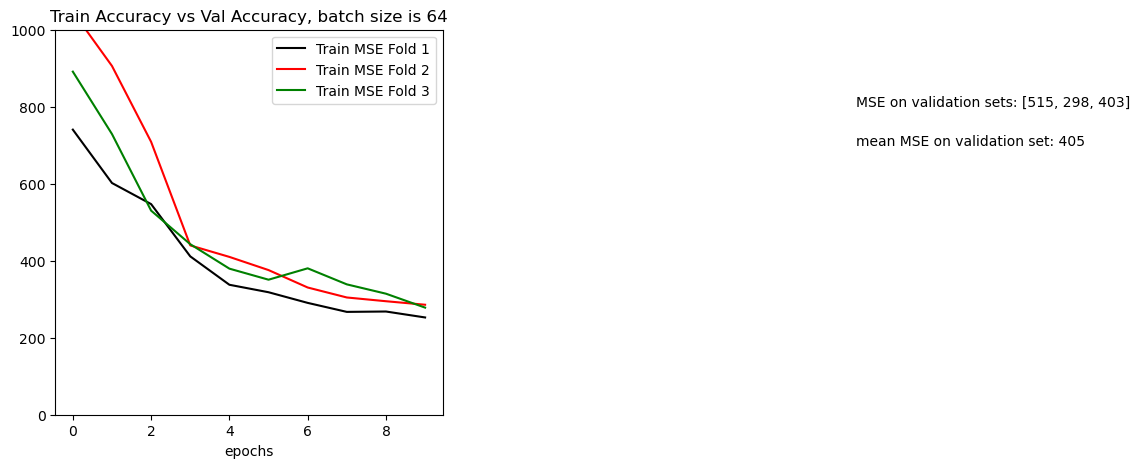

In [31]:
plt.figure(figsize=(5,5))
plt.title('Train Accuracy vs Val Accuracy, batch size is 64')
colors=['black','red','green']
for i in range(3):
    plt.plot(model_history[i].history['mean_squared_error'], label='Train MSE Fold '+str(i+1), color=colors[i])
#     plt.plot(model_history[i].history['val_mean_squared_error'], label='Val MSE Fold '+str(i+1), color=colors[i], linestyle = "dashdot")

plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylim(0,1000)
plt.text(20,800,"MSE on validation sets: "+str([int(v) for v,v2 in val_scores]))
plt.text(20,700,"mean MSE on validation set: "+str(int(np.mean(val_scores,axis=0)[0])))
plt.show()

# LeNet

In [9]:
def train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size):
    reg_param = 1e-5
    
    train_X = tf.convert_to_tensor(train_x)
    train_Y = tf.convert_to_tensor(train_y)
    
    val_X = tf.convert_to_tensor(val_x)
    val_Y = tf.convert_to_tensor(val_y)
    
    weights_initializer = keras.initializers.GlorotUniform()
    

    model = keras.models.Sequential([
        
        Preprocessing(),
        keras.layers.Conv2D(filters=6, kernel_size=(5,5), strides=1, padding='valid', activation='relu', input_shape=(224,224,3)),
        keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2),
        keras.layers.Conv2D(filters=16, kernel_size=(5,5), strides=1, padding='valid', activation='relu'),
        keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2),
        keras.layers.Conv2D(filters=120, kernel_size=(5,5), strides=1, padding='valid', activation='relu'),
        keras.layers.Flatten(),
        keras.layers.Dense(84, activation='relu'),
        keras.layers.Dense(1, activation='relu'),
        
        
    ])
    #Compiling the model
    model.compile(optimizer=keras.optimizers.Adam(lr=5e-4, beta_1=0.99, beta_2=0.9999),
                  loss='mean_squared_error', 
                  metrics=['mean_squared_error'], 
                 )

    #Training the network
    history = model.fit(train_X,train_Y, 
         epochs=n_epochs,
         batch_size=batch_size, 
         verbose=1
        )
    
    val_score = model.evaluate(val_X, val_Y)
    print("Val Score: ",val_score)
    return history,val_score,model

In [10]:
model_history=[]
val_scores=[]
n_epochs=20
batch_size=64
train_x, val_x, train_y, val_y = train_test_split(X_irpmw, y, random_state = 101, test_size=0.1)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, random_state = 101, test_size=0.1)
history,val_score,model = train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size)
model_history.append(history)
val_scores.append(val_score)

Epoch 1/20
58/58 [==============================] - 13s 196ms/step - loss: 2308.5488 - mean_squared_error: 2308.5488
Epoch 2/20
58/58 [==============================] - 12s 207ms/step - loss: 837.4905 - mean_squared_error: 837.4905
Epoch 3/20
58/58 [==============================] - 12s 202ms/step - loss: 709.6970 - mean_squared_error: 709.6970
Epoch 4/20
58/58 [==============================] - 12s 201ms/step - loss: 526.1142 - mean_squared_error: 526.1142
Epoch 5/20
58/58 [==============================] - 11s 193ms/step - loss: 434.7642 - mean_squared_error: 434.7642
Epoch 6/20
58/58 [==============================] - 11s 195ms/step - loss: 364.1141 - mean_squared_error: 364.1141
Epoch 7/20
58/58 [==============================] - 11s 195ms/step - loss: 325.8387 - mean_squared_error: 325.8387
Epoch 8/20
58/58 [==============================] - 11s 195ms/step - loss: 309.4426 - mean_squared_error: 309.4426
Epoch 9/20
58/58 [==============================] - 11s 196ms/step - loss: 302

In [11]:
y_pred = model.predict(test_x)
print('Testing...')
score = model.evaluate(test_x,test_y,
                     batch_size=16, verbose=1)
print('Test accuracy:', score[1])

13/13 [==============================] - 1s 37ms/step
Testing...
26/26 [==============================] - 1s 26ms/step - loss: 332.8715 - mean_squared_error: 332.8715
Test accuracy: 332.8714904785156


In [15]:
abcd = []
for x in y_pred:
    abcd.append(int(x))
    
cate = []
for x in abcd:
    if x <=33:
        cate.append('Tropical Depression')
    elif x>33 and x<=63:
        cate.append('Tropical Storm')
    elif x>63 and x<=129:
        cate.append('Typhoon')
    elif x>129:
        cate.append('Super Typhoon')
        
cate_dataset = list(zip(abcd,cate))
df = pd.DataFrame(cate_dataset,columns=['Intensity','Category',])
df

,Intensity,Category
0,51,Tropical Storm
1,43,Tropical Storm
2,25,Tropical Depression
3,49,Tropical Storm
4,29,Tropical Depression
...,...,...
408,18,Tropical Depression
409,34,Tropical Storm
410,39,Tropical Storm
411,27,Tropical Depression


# Xceptron Model

In [24]:
import tensorflow as tf
from tensorflow import keras

def train_val_model(train_x, train_y, val_x, val_y, n_epochs, batch_size):
    reg_param = 1e-5

    # Check the number of color channels in the input data
    print(train_x.shape, val_x.shape)

    # If the input data has only 2 channels, duplicate the second channel to get 3 channels
    if train_x.shape[-1] == 2:
        train_x = tf.concat([train_x, train_x[..., 1:2]], axis=-1)
        val_x = tf.concat([val_x, val_x[..., 1:2]], axis=-1)

    # Resize the images to match the expected input shape of the model
    train_x = tf.image.resize(train_x, [224, 224])
    val_x = tf.image.resize(val_x, [224, 224])

    weights_initializer = keras.initializers.GlorotUniform()

    # Creating an Xception model
    base_model = keras.applications.Xception(weights=None, include_top=False, input_shape=(224, 224, 3), pooling='avg')
    x = base_model.output
    x = keras.layers.Dense(256, activation='relu', kernel_initializer=weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param))(x)
    x = keras.layers.Dense(128, activation='relu', kernel_initializer=weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param))(x)
    output_layer = keras.layers.Dense(1, activation='relu', kernel_initializer=weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param))(x)
    model = keras.Model(inputs=base_model.input, outputs=output_layer)

    # Freezing the layers of the Xception model
    for layer in base_model.layers:
        layer.trainable = False

    # Compiling the model
    model.compile(optimizer=keras.optimizers.Adam(lr=5e-4, beta_1=0.99, beta_2=0.9999),
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'],
                  )

    # Training the network
    history = model.fit(train_x, train_y,
                        epochs=n_epochs,
                        batch_size=batch_size,
                        verbose=1
                        )

    # Unfreezing the last layers of the Xception model for fine-tuning
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    # Recompiling the model for fine-tuning
    model.compile(optimizer=keras.optimizers.Adam(lr=1e-5, beta_1=0.99, beta_2=0.9999),
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'],
                  )

    # Fine-tuning the network
    history = model.fit(train_x, train_y,
                        epochs=n_epochs,
                        batch_size=batch_size,
                        validation_data=(val_x, val_y),
                        verbose=1
                        )

    val_score = model.evaluate(val_x, val_y)
    print("Val Score: ", val_score)
    return history, val_score, model


In [26]:
model_history=[]
val_scores=[]
n_epochs=5
batch_size=64
train_x, val_x, train_y, val_y = train_test_split(X_irpmw, y, random_state = 101, test_size=0.1)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, random_state = 101, test_size=0.1)
history,val_score,model = train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size)
model_history.append(history)
val_scores.append(val_score)

(3709, 201, 201, 2) (458, 201, 201, 2)
Epoch 1/5
58/58 [==============================] - 240s 4s/step - loss: 2889.8611 - mean_squared_error: 2889.8545
Epoch 2/5
58/58 [==============================] - 238s 4s/step - loss: 1871.6187 - mean_squared_error: 1871.6112
Epoch 3/5
58/58 [==============================] - 234s 4s/step - loss: 873.9651 - mean_squared_error: 873.9529
Epoch 4/5
58/58 [==============================] - 234s 4s/step - loss: 998.8879 - mean_squared_error: 998.8735
Epoch 5/5
58/58 [==============================] - 237s 4s/step - loss: 773.8726 - mean_squared_error: 773.8605
Epoch 1/5
58/58 [==============================] - 379s 7s/step - loss: 916224.1875 - mean_squared_error: 916224.1875 - val_loss: 1215.5424 - val_mean_squared_error: 1215.5312
Epoch 2/5
58/58 [==============================] - 371s 6s/step - loss: 499256.0938 - mean_squared_error: 499256.0938 - val_loss: 1142.7224 - val_mean_squared_error: 1142.7117
Epoch 3/5
58/58 [============================